---
title: Parameter Estimation
layout: collection
permalink: /Computational-Biology/Parameter-Estimation
collection: Computational-Biology
mathjax: true
toc: true
categories:
  - study
tags:
  - mathematics
  - statistics
---

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Taxi cab problem

Imagine we observe $c$ taxi cabs, with $m$ being the largest one. We set our hypothisis as $\mathcal{H}_n$ that there are in total $n$ taxis. We use a
 uniform prior $\mathbb{P}(\mathcal{H_n} | I) = \text{constant}$ and define our likelihood as $\mathbb{P}(\mathcal{D} | \mathcal{H_n} I) = 
 \frac{\theta(n - m)}{n \cdot (n - 1) \cdot ... \cdot (n - c + 1)}$, where $\theta(x)$ is zero when $x < 0$ and 1 if $x \geq 0$. We can then 
 calculate the probability of how many taxis there are in total, which is given by the posterior:

$$
\mathbb{P}(\mathcal{H}_n | \mathcal{D} I) = \frac{\frac{\theta(n - m)}{n \cdot (n - 1) \cdot ... \cdot (n - c + 1)}}{\sum_{i = m}^{k} 
\frac{1}{i \cdot (i - 1) \cdot ... \cdot (i - c + 1)}}
$$

Here we just set k to 1000 as an upper limit. Then we can calculate our $n$ for a certain confidence, for example 95%:

$$
\sum_k \mathbb{P}(H_k | \mathcal{D} I) < 0.95
$$

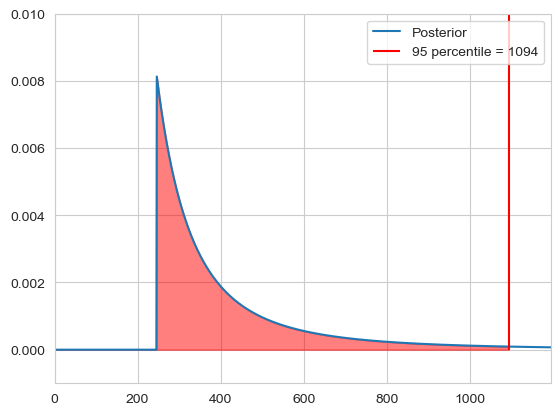

In [5]:
data = [33, 125, 246]
upper = 1000000
n = np.arange(0, upper + 1, 1)

likelihood = []
for i in n:
    if (i - max(data)) >= 0:
        likelihood.append(np.exp(-np.log(i) - np.log(i - 1) - np.log(i - 2)))
    else:
        likelihood.append(0)    

evidence = np.sum(likelihood)
posterior = likelihood / evidence

n_95 = np.argmax(np.cumsum(posterior) > 0.95)

plt.plot(n, posterior, label='Posterior')
plt.fill_between(n[:n_95], posterior[:n_95], alpha=0.5, color='red')
plt.vlines(n_95, ymin=0, ymax=0.5, color='red', label=f'95 percentile = {n_95}')
plt.legend()
plt.ylim([-0.001, 0.01])
plt.xlim([0, n_95 + 100])
plt.show()

For large $m$ we can again approximate the factorial by the power $\frac{1}{n \cdot(n - 1) \cdot ... \cdot (n - c + 1)} \approx \frac{1}{n^c}$ 
and calculate our normalisation constant as 

$$
Z = \int_m^{\infty} n^{-c} = -\frac{1}{c-1} n^{-c + 1}  \Bigr|^{\infty}_m = \frac{1}{c-1} m^{-c + 1}
$$

Thus we get the distribution

$$
\mathbb{P}(\mathcal{H}_n | m, c, I) \approx \theta(n - m) \frac{c-1}{m} \left( \frac{n}{m} \right)^{-c}
$$

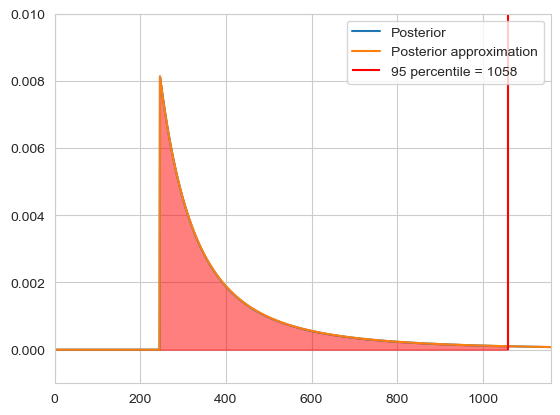

In [6]:
data = [33, 125, 246]
upper = 1000000
n = np.arange(0, upper + 1, 1)

c = len(data)
m = max(data)

posterior_approx = []
for i in n:
    if i >= m:
        posterior_approx.append(((c - 1) / m) * (i / m)**(-c)) 
    else:
        posterior_approx.append(0)

n_95 = np.argmax(np.cumsum(posterior_approx) > 0.95)

plt.plot(n, posterior, label='Posterior')
plt.plot(n, posterior_approx, label='Posterior approximation')
plt.fill_between(n[:n_95], posterior[:n_95], alpha=0.5, color='red')
plt.vlines(n_95, ymin=0, ymax=0.5, color='red', label=f'95 percentile = {n_95}')
plt.legend()
plt.ylim([-0.001, 0.01])
plt.xlim([0, n_95 + 100])
plt.show()

Features of this distribution are:

Mode is always at $n = m$ <br>

We can find our $\alpha$ % intervall by calculating the probablity: 

$$
\sum_{k=n}^{\infty} \mathbb{P}(\mathcal{H}_n | m, c, I) = 1 - \alpha = \epsilon \approx \frac{c-1}{m} \int_n^{\infty} \left( \frac{k}{m} \right)^{-c} dk = \left( \frac{n}{m} \right)^{-c} \Rightarrow n  = m \epsilon^{-1/(c-1)}
$$

Where does get our intervall $[m, m \epsilon^{-1/(c-1)}]$.

The mean is given by 

$$
\langle n \rangle \approx \int_m^{\infty} n \mathbb{P}(n | m, c, I)dn = \int_m^{\infty} n \frac{c-1}{m} \left( \frac{n}{m} \right)^{-c} dn
= \frac{c-1}{m^{-c + 1}} \int_m^{\infty} n^{-(c - 1)} dn = \frac{c-1}{m^{-c + 1}} \left[- \frac{1}{c-2}  n^{-(c - 2)} \right]^{\infty}_{m} = \frac{c-1}{m^{-c + 1}} \frac{1}{c-2}  m^{-(c - 2)} = \frac{c-1}{c-2}m
$$

The median is given by

$$
\int_{n_{0.5}}^{\infty} \mathbb{P}(n | m, c, I)dn \overset{!}{=}0.5 \Rightarrow \left( \frac{n_{0.5}}{m} \right)^{-c} = 0.5 \Leftrightarrow n_{0.5} = m2^{1/(c-1)}
$$

But the question that remains is, which is the best function to describe our $n$?

We define the loss function $L(r, n)$ which gives us a cost (penalty) for predicting a value $r$ if the the true value is $n$. Then logically we want to minimize our penalty for guessing a value $r$, so we pick $r$ which minimizes our loss function.

$$
\langle L(r) \rangle = \sum_n L(r, n) \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I)
$$

#### Linear loss

The linear loss function is given by $L(r, n) = |r - n|$. To then minimize this function, we know that $\langle L(r) \rangle$ is a strict 
convex function, which has a definit minima so we take it's derivate and set it to zero

$$
\frac{d \langle L(r) \rangle }{dr} = \frac{d}{dr} \sum_n |r - n| \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) =\frac{d}{dr} \left( \sum_{r < n}
 (r - n) \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) - \sum_{r > n} (r - n) \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) \right) = \sum_{r < n} 
 \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) - \sum_{r > n} \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) \overset{!}{=} 0 \\
\Leftrightarrow \mathbb{P}(n < r | \mathcal{D}, I) = \mathbb{P}(n > r | \mathcal{D}, I) \Rightarrow r = n_{0.5}
$$

#### Quadratic loss

The quadratic loss function is given by $L(r, n) = (r - n)^2$. Same rules apply and we get:

$$
\frac{d \langle L(r) \rangle }{dr} = \frac{d}{dr} \sum_n (r - n)^2 \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) = 2 \sum_n (r - n) 
\mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) \overset{!}{=}0 \Leftrightarrow r
\underbrace{\sum_n \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I)}_{=1} = \sum_n n \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) \\
\Rightarrow r = \langle n \rangle
$$

#### Delta loss

The delta loss function is given by $L(r, n) = 1 - \delta(r, n)$, where $\delta(r, n)$ is 0 for r = n and 1 everywhere else.

$$
\langle L(r) \rangle = \sum_n (1 - \delta(r, n)) \mathbb{P}(\mathcal{H}_n | \mathcal{D}, I) = 1 - \mathbb{P}(\mathcal{H}_r | \mathcal{D}, I)
$$ 

This function clearly takes it's minima at the value of $r$ which has the highest probability, which is the mode $r = n_*$

### Probability density

Let $p$ be a probability, then $\mathbb{P}(p \| \mathcal{D}, I)dp$ is the probability that $p$ lies in between $p$ and $p + dp$. If we then want to 
find the probability that $p$ is in a given intervall, for continous problems we can calculate this by an integral

$$
\mathbb{P}(p \in [p - \epsilon, p + \epsilon] | \mathcal{D}) = \int_{p - \epsilon}^{p + \epsilon} \mathbb{P}(p | \mathcal{D})dp; \quad \epsilon > 0
$$

#### Beta distribution

Using a uniform prior $\mathbb{P}(p | I)dp = 1dp$ and a binomial distribution where thus the likelihood looks like 
$\mathbb{P}(\mathcal{D}|p, I) = \begin{pmatrix} n \\ k \end{pmatrix} p^k (1 - p)^{n - k}$ we get the posterior for our probability p given the data as:

$$
\mathbb{P}(p |\mathcal{D}, I) = \frac{\mathbb{P}(\mathcal{D} | p, I)\mathbb{P}(p | I)}{\mathbb{P}(\mathcal{D} | I)}
= \frac{\begin{pmatrix} n \\ k \end{pmatrix} p^k (1 - p)^{n - k}}{\int_0^1 \begin{pmatrix} n \\ k \end{pmatrix} q^k (1 - q)^{n - k} dq} dp
= \frac{p^k (1 - p)^{n - k}}{\int_0^1 q^k (1 - q)^{n - k} dq} dp
= \frac{(n+1)!}{k!(n-k)!} p^k (1-p)^{n-k}dp
$$

This is called the beta distribution. The general form of the beta distribution is:

$$
\mathbb{P}(p | \alpha, \beta) = \frac{p^{\alpha - 1}(1 - p)^{\beta - 1}}{B(\alpha, \beta)}
$$

With $B(\alpha, \beta) = \int_0^1 p^{\alpha - 1} (1 - p)^{\beta - 1} = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$

The beta distribution has the following properties

It's mode is given by $p_* = \frac{\alpha - 1}{\alpha + \beta - 2}$

<details>
<summary> Proof </summary>

$$
\frac{1}{B(\alpha, \beta)} \frac{d}{dp} p^{\alpha - 1}(1 - p)^{\beta - 1} = 0 \Leftrightarrow (\alpha - 1)p^{\alpha - 2} (1 - p)^{\beta - 1} - 
(\beta - 1)p^{\alpha - 1} (1 - p)^{\beta - 2}\\ 
\Rightarrow (\alpha - 1)p^{\alpha - 2} (1 - p)^{\beta - 1} = (\beta - 1)p^{\alpha - 1} (1 - p)^{\beta - 2} \\
\Rightarrow (\alpha - 1) p^{-1} = (\beta - 1)(1 - p)^{-1} \\
\Rightarrow \alpha - 1 - p(\alpha - 1) = (\beta - 1)p \\
\Rightarrow \alpha - 1 = (\alpha + \beta - 2)p \\
\Rightarrow p_* = \frac{\alpha - 1}{\alpha + \beta - 2} \quad q.e.d
$$

</details>

It's mean is given by $\langle p \rangle = \frac{\alpha}{\alpha + \beta}$

<details>
<summary> Proof </summary>

$$
\int^1_0 p \frac{1}{B(\alpha, \beta)} p^{\alpha - 1}(1 - p)^{\beta - 1} = \frac{1}{B(\alpha, \beta)} \int^1_0 p^{\alpha}(1 - p)^{\beta - 1} = 
\frac{B(\alpha + 1, \beta)}{B(\alpha, \beta)} = \frac{\Gamma(\alpha + 1) \Gamma(\beta) \Gamma(\alpha+\beta)}{\Gamma(\alpha + \beta + 1)
\Gamma(\alpha) \Gamma(\beta)}
= \frac{\Gamma(\alpha + 1)\Gamma(\alpha+\beta)}{\Gamma(\alpha + \beta + 1)\Gamma(\alpha)}
$$

Then with $\Gamma(n + 1) = n!$ we get

$$
\Rightarrow \frac{\alpha! (\alpha+\beta - 1)!}{ (\alpha + \beta)! (\alpha - 1)!}
= \frac{\alpha}{ \alpha + \beta}

$$

</details>

The variance is given by $\langle p^2 \rangle - \langle p \rangle^2 = \frac{\langle p \rangle (1 - \langle p \rangle)}{\alpha + \beta + 1}$

### Transforming probability densities

Imagine we have a virus which kills cells at a constant rate per unit time $p(\text{die in time dt}) = \lambda dt$, if f(t) is the fraction of cells that are alive 
after time t we get 

$$
f(t + dt) = f(t)(1 - \lambda dt) \Leftarrow \frac{d f(t)}{dt} = - \lambda f(t) \Rightarrow f(t) = e^{-\lambda t} \Leftrightarrow t = - \frac{\ln (f)}{\lambda}
$$

Assume we collect $m$ infected cells and determine that $k$ of $m$ cells are still alive. With this we can estimate the total fraction of cells 
$p$ that is still alive. This is given by the beta distribution. But what if we're interested in the time $t$ at which the cells were infected? 
We then would like to be able to transform our posterior on the probability $\mathbb{P}(p, | m, k)dp$ into a posterior on the infection time
 $\tilde{\mathbb{P}}(t | m, k) dt$.

Given the function $t(p) = - \frac{\ln(p)}{\lambda}$, we know that the probability for $p$ to lie in a specific region is the same as for $t$ to 
lie in the corresponding region

$$
\mathbb{P}([p_{min}, p_{max}] | m, k) = \tilde{\mathbb{P}}([t(p_{max}), t(p_{min})] | m, k)
$$

Which is equivalent to the substitution $t(p) = - \frac{\ln (p)}{\lambda} \Rightarrow dt = - \frac{1}{p \lambda} dp$:
$$
\int_{p_{min}}^{p_{max}} \mathbb{P}(p | m, k) dp = - \int_{t(p_{max})}^{t(p_{min})} \tilde{\mathbb{P}}(t | m, k) dt = 
\int_{t(p_{min})}^{t(p_{max})} \frac{1}{\lambda p} \tilde{\mathbb{P}}(t | m, k) dt
$$

From which follows then the rule of transformation:

$$
\tilde{\mathbb{P}}(t | m, k) = \mathbb{P}(f(t) | m, k) \left| \frac{df}{dt} \right|
$$

Here then we get the specific distribution

$$
\tilde{\mathbb{P}}(t | m, k)dt = \lambda p \mathbb{P}(p | m, k) = = \lambda e^{-\lambda t} \frac{(m+1)!}{k!(m-k)!} e^{-\lambda t k} 
(1-e^{-\lambda t})^{m-k}dt 
= \lambda \frac{(m+1)!}{k!(m-k)!} e^{-\lambda t (k + 1)} (1-e^{-\lambda t})^{m-k}dt 
$$